### Déf : 
Entrée = id d'un cours que ous voulons évaluer
Sortie = 
* évaluation de la difficulté des problèmes liés à ce cours
* évaluation du niveau des élèves

### Méthode :
Méthode linéaire, basée sur le nombre de soumissions.

Chaque problème est évalué selon le rapport de entre les soumissions correctes et incorrectes lui étant relative.

Le niveau d'un élève correspond à l'addition des difficultés de chaque problème que il à résolu.

In [1]:
%matplotlib inline
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import psycopg2

con = psycopg2.connect("dbname=test1")

# Définition du course_id

In [2]:
course_id = "C00198"

# Réccupration des élèves d'un cours

Il faut premièrement récupérer la liste des users_id inscrits à ce cours

In [3]:
userslist = pd.read_sql_query("select user_id from coursesusers where course_id like '%s';" % course_id,con=con)
userslist = [u[0] for u in userslist.values if u[0]]
usersstr = str(userslist).strip('[]')

Ensuite nous pouvons récupérer les informations utiles de ces utilisateurs. En veillant à **éliminer** les ustilisateurs de type demo, instructor et administrator.

In [4]:
users = pd.read_sql_query("select user_id, creation_date from users \
                            where demo=0 and instructor=0 and administrator=0\
                            and user_id in (%s);" % usersstr,con=con)

usersstr = str(users.user_id.tolist()).strip('[]')

# Réccupration des problèmes d'un cours
Récupération de la liste des problem_nm d'un liés au cours sélectioné. Nous filtrons cette liste enutilisant que les problèmes de type *Pxxxxx*

## Get every lists of problems from the course id

In [5]:
problists = pd.read_sql_query("select list_id from courseslists where course_id like '%s';" % course_id ,con=con)
problists = [l[0] for l in problists.values if l[0]]
problistsstr = str(problists).strip('[]')

## Get every problems for each list id 

In [6]:
probs = pd.read_sql_query("select problem_nm from listitems where list_id \
                                in(%s);" % problistsstr,con=con)

lprobs = [p[0] for p in probs.values if p[0]]
lprobsstr = str(lprobs).strip('[]')

# Get soubmissions for each problems relative to user list

In [7]:
submissions = pd.read_sql_query("select submission_uid, user_id, problem_id, submission_id, \
                        state, time_out, time_in, veredict, score \
                        from submissions where user_id in (%s);" % (usersstr) ,
                       con=con)

## Get rid of language ids

In [8]:
submissions.problem_id = submissions.problem_id.apply(lambda x: x[:-3])
submissions.set_index('submission_uid', inplace=True)
submissions.describe()

,user_id,problem_id,submission_id,state,time_out,time_in,veredict,score
count,25201,25201,25201,25201,25201,25201,25201,135
unique,72,792,44,1,24962,25025,8,17
top,U14908,P71839,S001,done,2015-12-07 00:41:29,2015-12-22 13:45:08,AC,100/100
freq,2357,265,12239,25201,4,2,12206,45
first,NaN,NaN,NaN,NaN,2010-09-15 15:37:19,2010-09-15 10:38:24,NaN,NaN
last,NaN,NaN,NaN,NaN,2016-02-24 00:05:31,2016-02-24 00:05:22,NaN,NaN


## Select sublimissions from problem list

In [9]:
submissions = submissions[submissions.problem_id.isin(lprobs)]
submissions.describe()

,user_id,problem_id,submission_id,state,time_out,time_in,veredict,score
count,18790,18790,18790,18790,18790,18790,18790,0.0
unique,72,207,44,1,18607,18657,6,0.0
top,U14908,P34091,S001,done,2015-12-07 00:41:29,2015-12-03 12:56:05,AC,NaN
freq,1090,258,9357,18790,4,2,9344,NaN
first,NaN,NaN,NaN,NaN,2010-09-15 15:37:19,2010-09-15 10:38:24,NaN,NaN
last,NaN,NaN,NaN,NaN,2016-02-23 21:39:42,2016-02-23 21:39:33,NaN,NaN


In [10]:
goodSubs = submissions[submissions.veredict == 'AC']
badSubs = submissions[submissions.veredict != 'AC']

# Compute problems dificulty

In [11]:
def computeDifficulty(s):
    tot = submissions[(submissions.problem_id == s)].count().user_id
    bad = badSubs[(badSubs.problem_id == s)].count().user_id
    return np.divide(bad, tot, dtype=float)

def computeTot(s):
    return submissions[(submissions.problem_id == s)].count().user_id

def computeGoods(s):
    return goodSubs[(goodSubs.problem_id == s)].count().user_id

def computeBads(s):
    return badSubs[(badSubs.problem_id == s)].count().user_id

In [12]:
# probsEvaluation = probs.set_index('problem_nm')
probsEvaluation = probs.copy()
#probsEvaluation['Difficulty'] = computeDifficulty(probsEvaluation['problem_nm'])
probsEvaluation['Difficulty'] = map(computeDifficulty, probsEvaluation['problem_nm'])
probsEvaluation['Submissions'] = map(computeTot, probsEvaluation['problem_nm'])
probsEvaluation['Goods'] = map(computeGoods, probsEvaluation['problem_nm'])
probsEvaluation['Bads'] = map(computeBads, probsEvaluation['problem_nm'])

#probsEvaluation['TotSubs'] = submissions[submissions.problem_id == probsEvaluation.problem_nm].count().user_id

In [13]:
probsEvaluation.sort_values(['Difficulty', 'Bads'], inplace=True, ascending=True)

In [14]:
# probsEvaluation.set_index('problem_nm', inplace=True)
probsEvaluation

,problem_nm,Difficulty,Submissions,Goods,Bads
53,P86578,0.000000,4,4,0
134,P10694,0.017857,56,55,1
133,P79860,0.033898,59,57,2
21,P85370,0.047619,21,20,1
64,P41221,0.052632,76,72,4
135,P20006,0.131148,61,53,8
132,P62467,0.142857,70,60,10
160,P67454,0.145161,62,53,9
112,P13623,0.185185,81,66,15
23,P63888,0.190476,21,17,4


# Evaluate User Ability

* Get all accepted submissions from a user
* Add the relative difficulty

## Example for user 0

In [15]:
userslist[0]

'U16609'

In [16]:
### get his submissions
subs = goodSubs[goodSubs.user_id == userslist[0]]

In [17]:
subs.describe()

,user_id,problem_id,submission_id,state,time_out,time_in,veredict,score
count,100,100,100,100,100,100,100,0.0
unique,1,96,4,1,100,100,1,0.0
top,U16609,P67723,S001,done,2015-11-27 00:35:42,2015-11-19 19:51:11,AC,NaN
freq,100,2,79,100,1,1,100,NaN
first,NaN,NaN,NaN,NaN,2015-10-12 11:32:45,2015-10-12 11:32:38,NaN,NaN
last,NaN,NaN,NaN,NaN,2015-11-27 01:43:29,2015-11-27 01:43:23,NaN,NaN


We can see that there is 100 submission accepted but 96 different problems. That means that the user submited several correct solutions for a same problem. We need to count unique probleme only.

In [18]:
upbs = pd.unique(subs.problem_id)
upbs

array(['P68688', 'P57548', 'P41221', 'P56118', 'P52847', 'P90615',
       'P48107', 'P15613', 'P37469', 'P34279', 'P81629', 'P61634',
       'P51126', 'P56559', 'P89265', 'P37500', 'P59539', 'P59875',
       'P97156', 'P69277', 'P31170', 'P50327', 'P28754', 'P60816',
       'P78142', 'P55622', 'P79784', 'P39057', 'P67723', 'P96767',
       'P72986', 'P38045', 'P57846', 'P73231', 'P57474', 'P17913',
       'P88790', 'P57852', 'P96564', 'P55722', 'P77686', 'P95401',
       'P58459', 'P34091', 'P79817', 'P90133', 'P33839', 'P29973',
       'P72484', 'P42280', 'P13623', 'P19991', 'P80660', 'P58153',
       'P24080', 'P34080', 'P39359', 'P35080', 'P61061', 'P12509',
       'P61384', 'P42523', 'P51222', 'P35537', 'P96965', 'P61930',
       'P22467', 'P56549', 'P93533', 'P62467', 'P79860', 'P10694',
       'P20006', 'P45102', 'P85288', 'P37257', 'P71753', 'P17179',
       'P73501', 'P33371', 'P89851', 'P81585', 'P18298', 'P29253',
       'P23001', 'P89872', 'P75149', 'P89078', 'P39225', 'P274

From that list of unique accepted problems, we need to add up every related difficulty to get a linear approximation of the User ability

In [19]:
pbs = probsEvaluation[probsEvaluation.problem_nm.isin(upbs.tolist())]
userAbility = pbs.Difficulty.sum()
print("Ability for User %s => %.2f" % (userslist[0], userAbility) )

Ability for User U16609 => 37.11


## Let s repeat that process for every user in the list

In [20]:
def computAbility(uid):
    subs = goodSubs[goodSubs.user_id == uid]
    upbs = pd.unique(subs.problem_id)
    pbs = probsEvaluation[probsEvaluation.problem_nm.isin(upbs.tolist())]
    return pbs.Difficulty.sum() # userAbility

def computeTotal(s):
    return submissions[(submissions.user_id == s)].count().problem_id


In [21]:
users['Ability'] = map(computAbility, users.user_id)
users['Total'] = map(computeTotal, users.user_id)

In [22]:
users.sort_values(['Ability'], inplace=True)
users.describe()

,Ability,Total
count,72.000000,72.000000
mean,53.577579,260.972222
std,23.742746,155.997199
min,0.288136,1.000000
25%,44.206289,170.750000
50%,57.517001,279.500000
75%,71.544061,328.750000
max,92.506746,1090.000000


## Confrontation de l'abilté des users par rapport au nombre total de soumissions

<IPython.core.display.Javascript object>


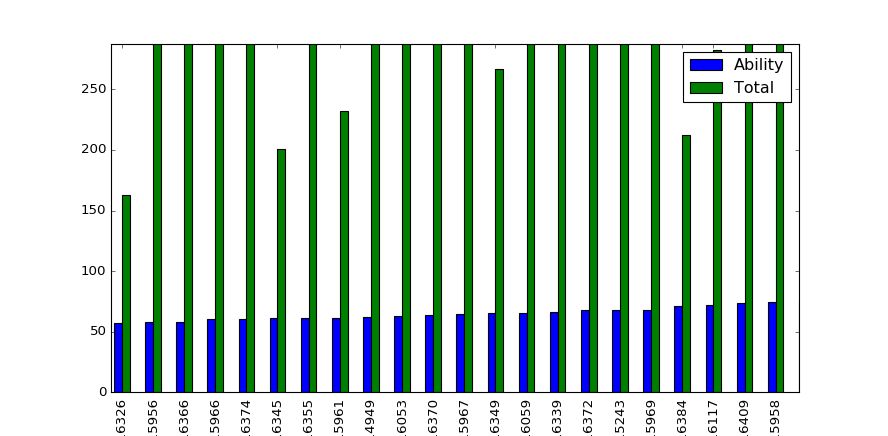

In [24]:
#plop = users[['creation_date', 'Ability', 'Total']]
plop = users[['user_id', 'Ability', 'Total']]
# plop.sort_index(inplace=True)
# plop.set_index('creation_date', inplace=True)
plop.set_index('user_id', inplace=True)
plop.plot(kind='bar')

<IPython.core.display.Javascript object>


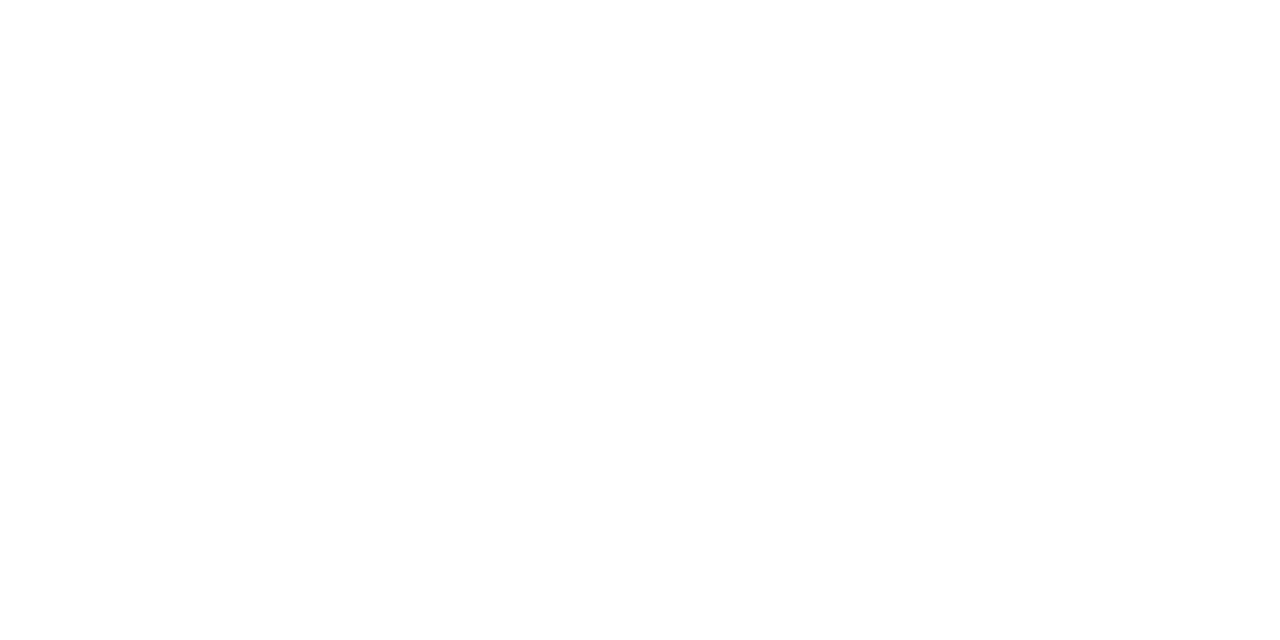

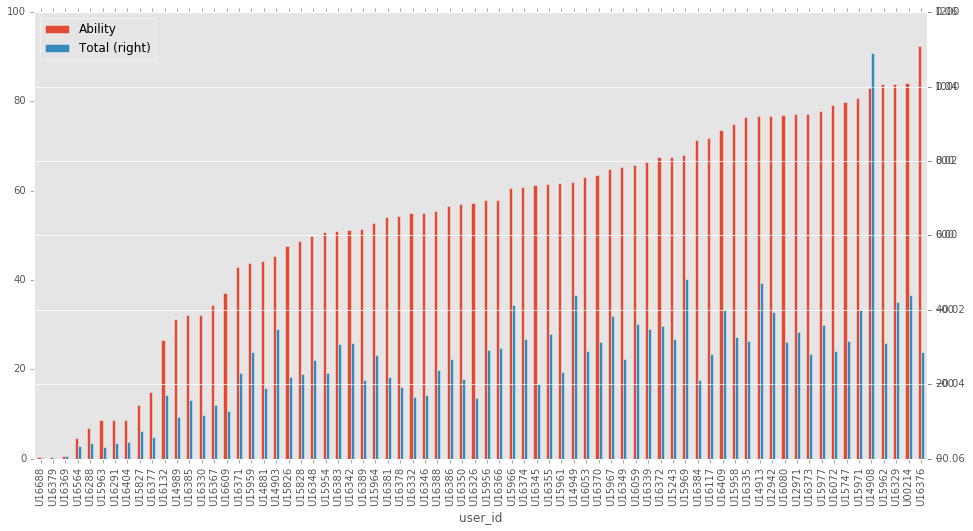

In [58]:
ax = plop.plot(kind='bar', figsize=(16,8), secondary_y='Total')
ax2 = ax.twinx()
ax2.set_yscale('linear')